# The LSTM Model Using Historical Data Only
## Table of Contents

1. [Import Libraries](#Import_Libraries)
2. [Setup MLFlow Tracking](#MLFlow_Tracking)
3. [Load Data](#Load_Data)
4. [Pre-Process Data](#Pre_Processing)


5. Product Categories
   
   5.1 [Bed, Bath and Table](#bed_bath_table) 
   
   5.2 [Health and Beauty](#health_beauty)
   
   5.3 [Sports and Leisure](#sports_leisure)
   
   5.4 [Furniture Decor](#furniture_decor)
   
   5.5 [Watches and Gifts](#watches_gifts)
   
   5.6 [Telephony](#telephony)
   
   5.7 [Housewares](#housewares)


# Import Libraries <a name = "Import_Libraries"/>

In [1]:
from utils import utils, metrics, dataset_2
import json
from pprint import pprint
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import mlflow


# Setup MLFlow Tracking <a name = "MLFlow_Tracking"/>

https://www.mlflow.org/docs/latest/tracking.html

In [2]:
# If this is the first time running the notebook, uncomment next line.
#This is to create a file called mlruns which will store the logs for each time the notebook is run

#mlflow_experiment_id = mlflow.create_experiment('Olist_LSTM_Historical_MLFlow')

#else:
mlflow.set_experiment('Olist_LSTM_Historical_MLFlow')
client = mlflow.tracking.MlflowClient()
# See ui 
#!mlflow ui

# Load Data <a name = "Load_Data"/>

In [3]:
# Read Config file
config = "configs_LSTM.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2017-12-14',
           'test_start': '2017-12-1',
           'train_start': '2017-07-01',
           'valid_start': '2017-11-21'},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': True,
 'end_date': '2017-12-31 23:59:59',
 'pre_processing': {'add_date_features': False,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'prefix_name': 'lag',
                    'window_size': 55},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm_product_category': False,
 'start_date': '2016-11-01 00:00:00',
 'state': 

# Pre-Process Training, Validation and Test Datasets <a name = "Pre_Processing"/>

In [4]:
df_train, df_valid, df_test = dataset_2.make_dataset(config)



# Product Category 1: Bed, Bath and Table <a name = "bed_bath_table"/>

In [5]:
#Filter on product categories (series)
bed_bath_table_train = df_train.loc[df_train['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_valid = df_valid.loc[df_valid['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_test = df_test.loc[df_test['product_category_name'] == 'bed_bath_table'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

bed_bath_table_train.drop(columns, inplace=True, axis=1)
bed_bath_table_valid.drop(columns, inplace=True, axis=1)
bed_bath_table_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
bed_bath_table_train = bed_bath_table_train[bed_bath_table_train.columns[::-1]].dropna()
bed_bath_table_valid = bed_bath_table_valid[bed_bath_table_valid.columns[::-1]]
bed_bath_table_test = bed_bath_table_test[bed_bath_table_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
bed_bath_table_train = scaler.fit_transform(bed_bath_table_train)
bed_bath_table_valid = scaler.transform(bed_bath_table_valid)
bed_bath_table_test = scaler.transform(bed_bath_table_test)

In [6]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(bed_bath_table_train)
df_valid_x, df_valid_y = split_reshape(bed_bath_table_valid)
df_test_x, df_test_y = split_reshape(bed_bath_table_test)

### Define Long Short Term Memory Model

In [7]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

C:\Users\feras\Anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\recurrent.py:808: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (isinstance(inputs, collections.Sequence)
C:\Users\feras\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:1389: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(sample_weight_mode, collections.Mapping):


In [9]:
mm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

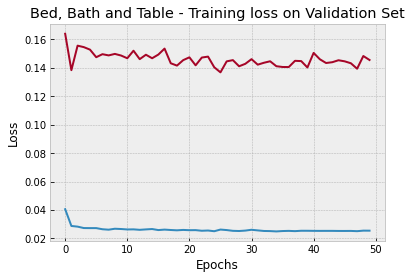

In [10]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Bed, Bath and Table - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Bed, Bath and Table')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 3449b01622214f2298ab442f847d7fed


In [12]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

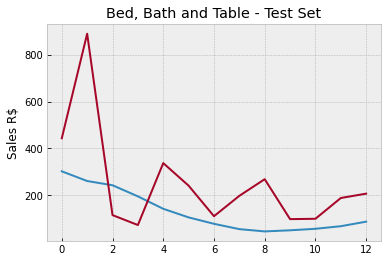

In [13]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Bed, Bath and Table - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

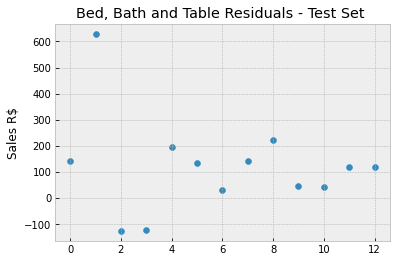

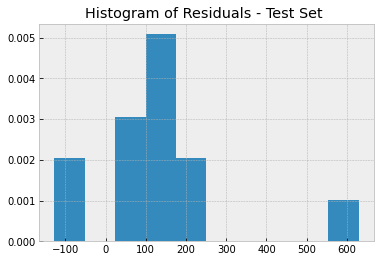

In [14]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Bed, Bath and Table Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [15]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 51186.58758695249
rms: 216.24880773419565
r2: -0.05051082300398524
mape: 0.6833586357865141


# Product Category 2: Heath & Beauty <a name = "health_beauty"/>

In [16]:
#Filter on product categories (series)
health_beauty_train = df_train.loc[df_train['product_category_name'] == 'health_beauty'].copy()
health_beauty_valid = df_valid.loc[df_valid['product_category_name'] == 'health_beauty'].copy()
health_beauty_test = df_test.loc[df_test['product_category_name'] == 'health_beauty'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

health_beauty_train.drop(columns, inplace=True, axis=1)
health_beauty_valid.drop(columns, inplace=True, axis=1)
health_beauty_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
health_beauty_train = health_beauty_train[health_beauty_train.columns[::-1]].dropna()
health_beauty_valid = health_beauty_valid[health_beauty_valid.columns[::-1]]
health_beauty_test = health_beauty_test[health_beauty_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
health_beauty_train = scaler.fit_transform(health_beauty_train)
health_beauty_valid = scaler.transform(health_beauty_valid)
health_beauty_test = scaler.transform(health_beauty_test)

In [17]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(health_beauty_train)
df_valid_x, df_valid_y = split_reshape(health_beauty_valid)
df_test_x, df_test_y = split_reshape(health_beauty_test)

### Define Long Short Term Memory Model

In [18]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [19]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [20]:
mm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

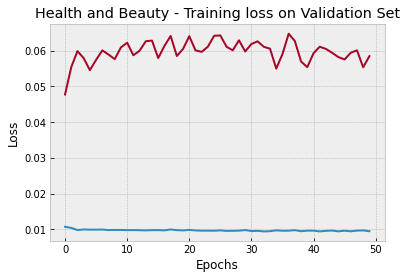

In [21]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Health and Beauty - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [22]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Health and Beauty')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: b1fd84a543ad4c51b7aadd347cdb6141


In [23]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

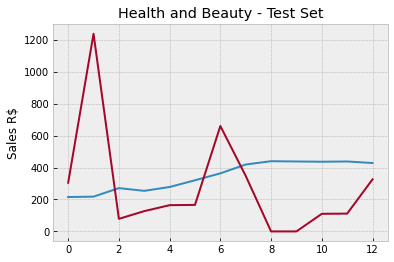

In [24]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Health and Beauty - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

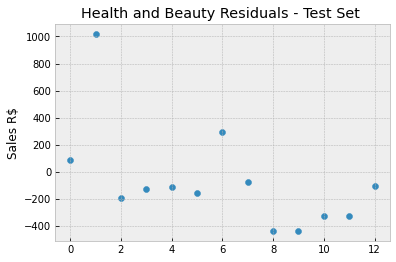

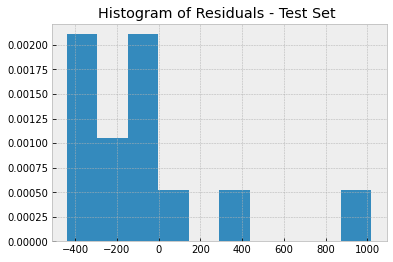

In [25]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Health and Beauty Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [26]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 108083.53837345833
rms: 376.08252107177003
r2: -0.33969524737600376
mape: 68.47938834116806


# Product Category 3: Sports and Leisure <a name = "sports_leisure"/>

In [27]:
#Filter on product categories (series)
sports_leisure_train = df_train.loc[df_train['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_valid = df_valid.loc[df_valid['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_test = df_test.loc[df_test['product_category_name'] == 'sports_leisure'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

sports_leisure_train.drop(columns, inplace=True, axis=1)
sports_leisure_valid.drop(columns, inplace=True, axis=1)
sports_leisure_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
sports_leisure_train = sports_leisure_train[sports_leisure_train.columns[::-1]].dropna()
sports_leisure_valid = sports_leisure_valid[sports_leisure_valid.columns[::-1]]
sports_leisure_test = sports_leisure_test[sports_leisure_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
sports_leisure_train = scaler.fit_transform(sports_leisure_train)
sports_leisure_valid = scaler.transform(sports_leisure_valid)
sports_leisure_test = scaler.transform(sports_leisure_test)

In [28]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(sports_leisure_train)
df_valid_x, df_valid_y = split_reshape(sports_leisure_valid)
df_test_x, df_test_y = split_reshape(sports_leisure_test)

### Define Long Short Term Memory Model

In [29]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [30]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [31]:
mm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

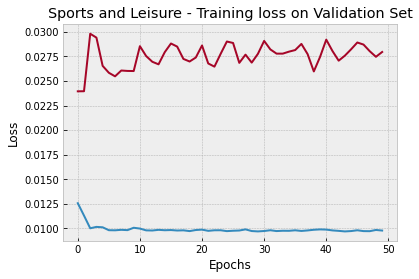

In [32]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Sports and Leisure - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [33]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Sports and Leisure')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 343a1859bbd54e60a13b18ef3d42cb7c


In [34]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

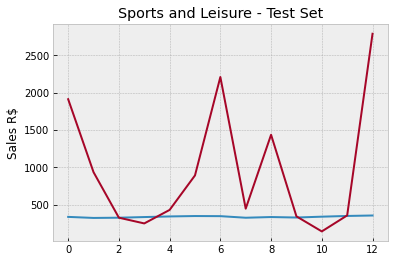

In [35]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Sports and Leisure - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

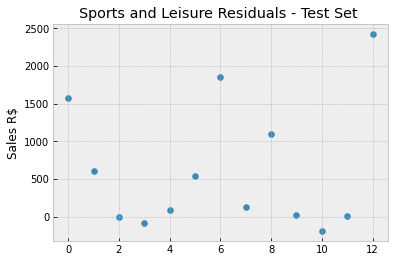

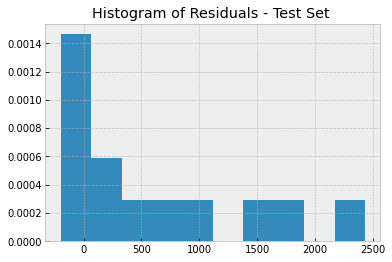

In [36]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Sports and Leisure Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [37]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 1021495.534424847
rms: 1029.8088069471619
r2: -0.5521471528336692
mape: 0.5222495700826255


# Product Category 4: Furniture Decor <a name = "furniture_decor"/>

In [38]:
#Filter on product categories (series)
furniture_decor_train = df_train.loc[df_train['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_valid = df_valid.loc[df_valid['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_test = df_test.loc[df_test['product_category_name'] == 'furniture_decor'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

furniture_decor_train.drop(columns, inplace=True, axis=1)
furniture_decor_valid.drop(columns, inplace=True, axis=1)
furniture_decor_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
furniture_decor_train = furniture_decor_train[furniture_decor_train.columns[::-1]].dropna()
furniture_decor_valid = furniture_decor_valid[furniture_decor_valid.columns[::-1]]
furniture_decor_test = furniture_decor_test[furniture_decor_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
furniture_decor_train = scaler.fit_transform(furniture_decor_train)
furniture_decor_valid = scaler.transform(furniture_decor_valid)
furniture_decor_test = scaler.transform(furniture_decor_test)

In [39]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(furniture_decor_train)
df_valid_x, df_valid_y = split_reshape(furniture_decor_valid)
df_test_x, df_test_y = split_reshape(furniture_decor_test)

### Define Long Short Term Memory Model

In [40]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [41]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [42]:
mm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

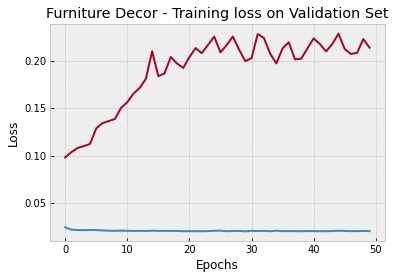

In [43]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Furniture Decor - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [44]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Furniture Decor')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 07a47476e8884589b4920e0fe77cd47a


In [45]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

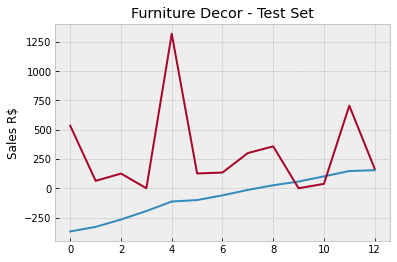

In [46]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Furniture Decor - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

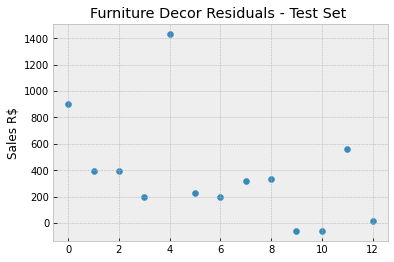

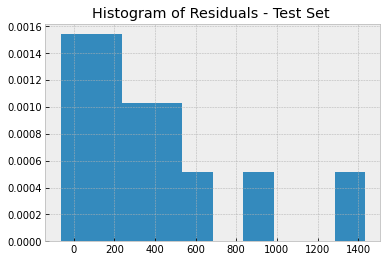

In [47]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Furniture Decor Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [48]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 182049.04329190103
rms: 543.1550811093726
r2: -1.2909883270226614
mape: 20.921273643746492


# Product Category 5: Watches Gifts <a name = "watches_gifts"/>

In [49]:
#Filter on product categories (series)
watches_gifts_train = df_train.loc[df_train['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_valid = df_valid.loc[df_valid['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_test = df_test.loc[df_test['product_category_name'] == 'watches_gifts'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

watches_gifts_train.drop(columns, inplace=True, axis=1)
watches_gifts_valid.drop(columns, inplace=True, axis=1)
watches_gifts_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
watches_gifts_train = watches_gifts_train[watches_gifts_train.columns[::-1]].dropna()
watches_gifts_valid = watches_gifts_valid[watches_gifts_valid.columns[::-1]]
watches_gifts_test = watches_gifts_test[watches_gifts_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
watches_gifts_train = scaler.fit_transform(watches_gifts_train)
watches_gifts_valid = scaler.transform(watches_gifts_valid)
watches_gifts_test = scaler.transform(watches_gifts_test)

In [50]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(watches_gifts_train)
df_valid_x, df_valid_y = split_reshape(watches_gifts_valid)
df_test_x, df_test_y = split_reshape(watches_gifts_test)

### Define Longh Short Term Memory Model

In [51]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [52]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [53]:
mm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

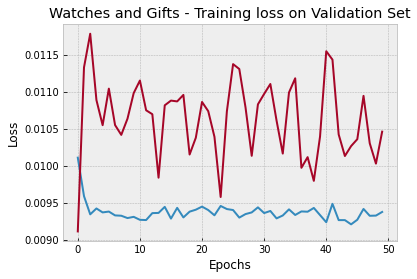

In [54]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Watches and Gifts - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [55]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Watches and Gifts')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 8c72b4985b8a4443b369f0f0f1b78cf8


In [56]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

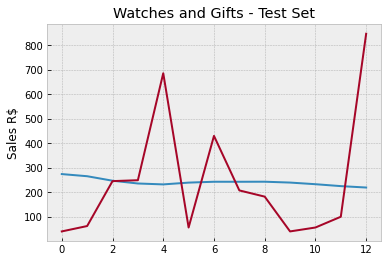

In [57]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Watches and Gifts - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

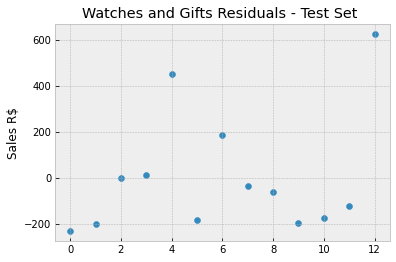

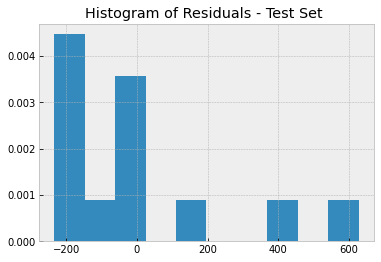

In [58]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Watches and Gifts Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [59]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 64212.14948280006
rms: 256.3557652595711
r2: -0.06240075491019348
mape: 1.7979685474705998


# Product Category 6: Telephony <a name = "telephony"/>

In [60]:
#Filter on product categories (series)
telephony_train = df_train.loc[df_train['product_category_name'] == 'telephony'].copy()
telephony_valid = df_valid.loc[df_valid['product_category_name'] == 'telephony'].copy()
telephony_test = df_test.loc[df_test['product_category_name'] == 'telephony'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

telephony_train.drop(columns, inplace=True, axis=1)
telephony_valid.drop(columns, inplace=True, axis=1)
telephony_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
telephony_train = telephony_train[telephony_train.columns[::-1]].dropna()
telephony_valid = telephony_valid[telephony_valid.columns[::-1]]
telephony_test = telephony_test[telephony_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
telephony_train = scaler.fit_transform(telephony_train)
telephony_valid = scaler.transform(telephony_valid)
telephony_test = scaler.transform(telephony_test)

In [61]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(telephony_train)
df_valid_x, df_valid_y = split_reshape(telephony_valid)
df_test_x, df_test_y = split_reshape(telephony_test)

### Define Long Short Term Memory Model

In [62]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [63]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [64]:
mm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

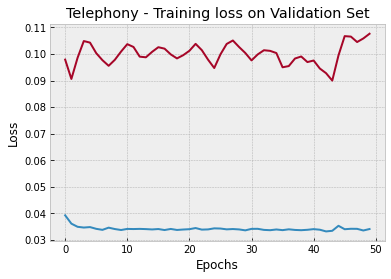

In [65]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Telephony - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [66]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Telephony')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: f58ff7a35a1f45538e74c19762ab4ba1


In [67]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

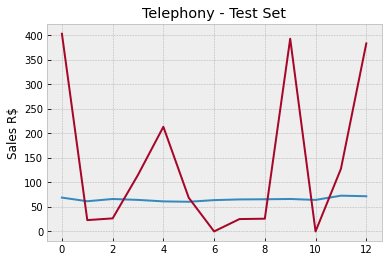

In [68]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Telephony - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

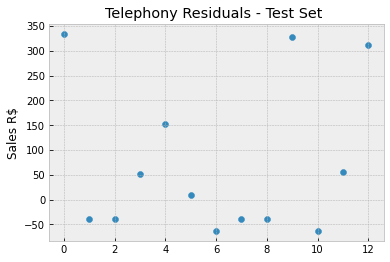

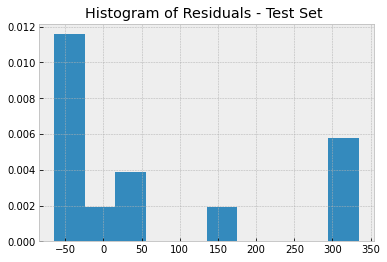

In [69]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Telephony Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [70]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 30519.181417712607
rms: 166.27845150690638
r2: -0.21382841502820593
mape: 10.64325398972358


# Product Category 7: Housewares <a name = "housewares"/>

In [71]:
#Filter on product categories (series)
housewares_train = df_train.loc[df_train['product_category_name'] == 'housewares'].copy()
housewares_valid = df_valid.loc[df_valid['product_category_name'] == 'housewares'].copy()
housewares_test = df_test.loc[df_test['product_category_name'] == 'housewares'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

housewares_train.drop(columns, inplace=True, axis=1)
housewares_valid.drop(columns, inplace=True, axis=1)
housewares_test.drop(columns, inplace=True, axis=1)

# re-sort columns from last to current and drop the first days
housewares_train = housewares_train[housewares_train.columns[::-1]].dropna()
housewares_valid = housewares_valid[housewares_valid.columns[::-1]]
housewares_test = housewares_test[housewares_test.columns[::-1]]

# Rescale the data, this will convert the dataframe into a numpy array
scaler = MinMaxScaler()
housewares_train = scaler.fit_transform(housewares_train)
housewares_valid = scaler.transform(housewares_valid)
housewares_test = scaler.transform(housewares_test)

In [72]:
# Reshape the data as input of the model is a 3D tensor, which will have:
# The first dimension  -> number of rows
# The second dimension -> history
# The third dimension  -> number of features (other series of same length)
def split_reshape(data):
    data_x = data[:,:-1].reshape(data.shape[0],data.shape[1]-1,1)
    data_y = data[:,-1]
    return data_x, data_y

df_train_x, df_train_y = split_reshape(housewares_train)
df_valid_x, df_valid_y = split_reshape(housewares_valid)
df_test_x, df_test_y = split_reshape(housewares_test)

### Define Long Short Term Memory Model

In [73]:
def a_model():
    num_timesteps = 55 # the number of lags in the dataframes
    num_series = 1     # the number of time series
    num_units = 100    # the number of hidden units
    
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(num_timesteps, num_series)))
    model.add(Dropout(0.1)) # Prevent overfitting
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [74]:
# Initialize model, specify the training data, to get the input shape
mm = a_model()

In [75]:
mm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Train Model, Report & Visualize Performance on the Validation Set

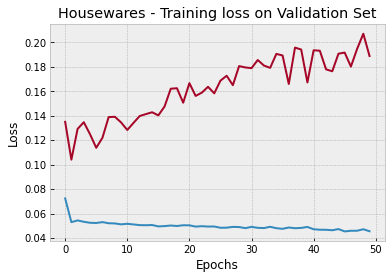

In [76]:
# Store the training in the history variable
history = mm.fit(df_train_x, df_train_y, validation_data=(df_valid_x, df_valid_y), epochs=50, verbose=0)
# See what is stored in the history
#history.history.keys()

#Plot training loss on validation set
loss = history.history["loss"]
vloss = history.history["val_loss"]

plt.plot(range(len(loss)), loss,)
plt.plot(range(len(loss)), vloss)


plt.title("Housewares - Training loss on Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [77]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_param('window_size', 55)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('num of units', 100)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('num of epochs', 50)
    mlflow.log_param('Product Category','Housewares')
                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 6e3445eb1ddd4eb99509cf0ef3fa3805


In [78]:
#metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True, param_prefix='validation')

### Plot Actuals & Forecasts

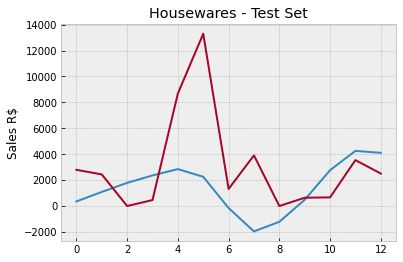

In [79]:
# To convert back the values to real sales, ctrl+f invert the scaling ->
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Invert scaling for forecasted values
# Concatenate column wise, remember initially we used the minmax scaler on a dataframe which is two 
# dimensions, but later df_test_x was converted into 3 dimensions, so we use squeeze to remove the last dim.
predicted = mm.predict(df_test_x)
inv_yhat = np.concatenate((predicted, df_test_x.squeeze()[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values - this should be the same original test labels ! And it is.
# add a dimension to the np.array df_test_y
df_test_y = df_test_y.reshape((len(df_test_y), 1))
inv_y = np.concatenate((df_test_y, df_test_x.squeeze()[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pd.Series(inv_yhat).plot()
pd.Series(inv_y).plot()
plt.title('Housewares - Test Set')
plt.ylabel('Sales R$')
plt.show()

### Plot Residuals

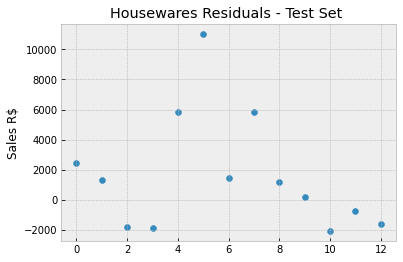

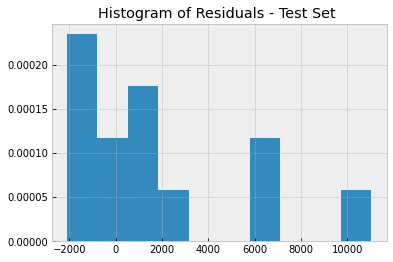

In [80]:
#Calcaulte Forecast Error
error = inv_y - inv_yhat 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Housewares Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Evaluate Performance

In [81]:
metrics.get_metrics(inv_y, inv_yhat, run_id = current_run_id, log=True , param_prefix='test')

wape: 14639391.543450894
rms: 4075.6928359859894
r2: -0.21237153026388045
mape: 232.14678803132423
